In [113]:
library(RBGL)
library(ggplot2)
library(dplyr, warn.conflicts = FALSE)
#library(tibble)
library("rjson")

source("lib/code_for_binary_simulations/blip_vs_bidag_plot.R")
source("lib/code_for_binary_simulations/summarySE.R")

In [114]:
config <- fromJSON(file = "config.json")

In [115]:
directory <- config$output_dir
dims <- config$dims
sample_sizes <- config$sample_sizes
replicates <- config$replicates$start:config$replicates$end
avparents <-config$av_parents

### Order MCMC

In [116]:
filenames <- list.files(pattern = "^(res_orderMCMC)", path = directory)
ROCdf_order_mcmc <- data.frame()
tmpdf <- 1
for (filename in filenames) {
    tmpdf <- read.csv(file.path(directory, filename))
    ROCdf_order_mcmc <- dplyr::bind_rows(ROCdf_order_mcmc, tmpdf)
}

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“bi

In [117]:
ROCdf_order_mcmc$algorithm <- apply(ROCdf_order_mcmc["itsearch_MAP"], 1, 
 function(a){
    if(a==TRUE){ 
        return("order_mcmc_itsearch_map")
     }else {
        return("order_mcmc_itsearch_sample")
      }
  })                                          

In [118]:
ROCdf_order_mcmc

TPR,FPRn,logscore,threshold,SHD,time,avparents,replicate,algorithm,dim,⋯,iterations,stepwise,alpha,cpdag,gamma,hardlimit,chainout,scoreout,verbose,itsearch_MAP
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<chr>,<int>,⋯,<lgl>,<lgl>,<dbl>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<int>
0.00,0.00,-1001.3166,0.99,20,3.101790,2,1,order_mcmc_itsearch_sample,20,⋯,NA,NA,0.05,False,1,15,True,False,False,0
0.10,0.05,-972.2616,0.95,21,3.101790,2,1,order_mcmc_itsearch_sample,20,⋯,NA,NA,0.05,False,1,15,True,False,False,0
0.30,0.05,-917.3552,0.90,19,3.101790,2,1,order_mcmc_itsearch_sample,20,⋯,NA,NA,0.05,False,1,15,True,False,False,0
0.45,0.05,-900.2088,0.80,17,3.101790,2,1,order_mcmc_itsearch_sample,20,⋯,NA,NA,0.05,False,1,15,True,False,False,0
0.50,0.05,-893.6663,0.70,16,3.101790,2,1,order_mcmc_itsearch_sample,20,⋯,NA,NA,0.05,False,1,15,True,False,False,0
0.75,0.15,-847.2704,0.60,16,3.101790,2,1,order_mcmc_itsearch_sample,20,⋯,NA,NA,0.05,False,1,15,True,False,False,0
0.75,0.20,-844.4266,0.50,17,3.101790,2,1,order_mcmc_itsearch_sample,20,⋯,NA,NA,0.05,False,1,15,True,False,False,0
0.80,0.35,NA,0.40,20,3.101790,2,1,order_mcmc_itsearch_sample,20,⋯,NA,NA,0.05,False,1,15,True,False,False,0
0.80,0.45,NA,0.30,23,3.101790,2,1,order_mcmc_itsearch_sample,20,⋯,NA,NA,0.05,False,1,15,True,False,False,0


In [119]:
sumROC_order_mcmc = ROCdf_order_mcmc %>%
                    filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%                    
                    filter(avparents %in% avparents) %>%       
                   filter(replicate %in% replicates) %>%
                    group_by(algorithm, threshold, sample_size, dim, avparents) %>% 
                    summarise( SHD_mean = mean(SHD),
                                TPR_mean = mean(TPR), 
                              TPR_median = median(TPR), 
                              FPRn_median = median(FPRn), 
                              TPR_q1 = quantile(TPR, probs = c(0.05)), 
                              TPR_q3 = quantile(TPR, probs = c(0.95)),
                              time_mean = mean(time),
                              logscore_mean = mean(logscore),
                              N = n())#%>%
                    #filter(N %in% replicates)

In [120]:
sumROC_order_mcmc

algorithm,threshold,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,logscore_mean,N
<chr>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
order_mcmc_itsearch_map,0.20,80,80,2,170.0,0.75625,0.75625,1.47500,0.750625,0.761875,23.95166,NA,2
order_mcmc_itsearch_map,0.30,80,80,2,148.5,0.74375,0.74375,1.18750,0.738125,0.749375,23.95166,NA,2
order_mcmc_itsearch_map,0.40,80,80,2,135.0,0.73750,0.73750,1.00625,0.726250,0.748750,23.95166,NA,2
order_mcmc_itsearch_map,0.50,80,80,2,121.5,0.71875,0.71875,0.81875,0.701875,0.735625,23.95166,-3196.525,2
order_mcmc_itsearch_map,0.60,80,80,2,110.0,0.63750,0.63750,0.65000,0.615000,0.660000,23.95166,-3283.099,2
order_mcmc_itsearch_map,0.70,80,80,2,105.0,0.60625,0.60625,0.56875,0.578125,0.634375,23.95166,-3324.568,2
order_mcmc_itsearch_map,0.80,80,80,2,97.0,0.54375,0.54375,0.43750,0.538125,0.549375,23.95166,-3389.042,2
order_mcmc_itsearch_map,0.90,80,80,2,84.5,0.43750,0.43750,0.24375,0.437500,0.437500,23.95166,-3512.873,2
order_mcmc_itsearch_map,0.95,80,80,2,83.0,0.33750,0.33750,0.17500,0.326250,0.348750,23.95166,-3619.591,2


### PC algorithm

In [121]:
filenames <- list.files(pattern = "^(res_pcalg)", path = directory)
roc_pcalg <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  roc_pcalg <- dplyr::bind_rows(roc_pcalg, tmpdf)
}

In [122]:
sum_roc_pcalg <- roc_pcalg %>% 
                 filter(dim %in% dims) %>%
                 filter(sample_size %in% sample_sizes) %>%         
                 filter(avparents %in% avparents) %>%
                filter(replicate %in% replicates) %>%
                 group_by(algorithm, alpha, sample_size, dim, avparents) %>% 
                 summarise(
                          SHD_mean = mean(SHD),
                          TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          time_mean = mean(time),
                          N = n())# %>% ungroup() %>%
#                 filter(N %in% replicates)

In [123]:
sum_roc_pcalg

algorithm,alpha,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N
<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
pcalg,0.01,80,80,2,66.0,0.40625,0.40625,0.01875,0.400625,0.411875,3.963813,2
pcalg,0.05,80,80,2,66.5,0.49375,0.49375,0.06250,0.488125,0.499375,5.780190,2
pcalg,0.10,80,80,2,73.0,0.53750,0.53750,0.13750,0.503750,0.571250,8.057484,2
pcalg,0.20,80,80,2,78.0,0.51250,0.51250,0.20000,0.501250,0.523750,13.520858,2
pcalg,0.35,80,80,2,82.5,0.53750,0.53750,0.27500,0.526250,0.548750,33.164629,2
pcalg,0.45,80,80,2,87.5,0.56875,0.56875,0.30625,0.563125,0.574375,60.242585,2


### Max-Min hill climbing

In [124]:
filenames <- list.files(pattern = "^(res_mmhc)", path = directory)
roc_mmhc <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  roc_mmhc <- dplyr::bind_rows(roc_mmhc, tmpdf)
}

In [125]:
sum_roc_mmhc <- roc_mmhc %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% avparents) %>% 
                filter(replicate %in% replicates) %>%
                 group_by(algorithm, alpha, sample_size, dim) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n()) #%>% ungroup() %>%
                    #filter(N %in% replicates)

In [126]:
sum_roc_mmhc

algorithm,alpha,sample_size,dim,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N
<fct>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
mmhc,0.01,80,80,58.0,0.4625,0.4625,0.01875,0.46250,0.46250,0.3501475,2
mmhc,0.05,80,80,61.0,0.5250,0.5250,0.08125,0.51375,0.53625,0.3680685,2
mmhc,0.10,80,80,64.5,0.5500,0.5500,0.13750,0.52750,0.57250,0.3485223,2
mmhc,0.20,80,80,64.5,0.5625,0.5625,0.15000,0.54000,0.58500,0.5326910,2
mmhc,0.35,80,80,68.5,0.5625,0.5625,0.20000,0.55125,0.57375,0.4918954,2
mmhc,0.45,80,80,70.0,0.5625,0.5625,0.21875,0.55125,0.57375,0.5431905,2


### Iterative MCMC

In [127]:
filenames <- list.files(pattern = "^(res_itsearch)", path = directory)
ROCdf_itsearch <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  # Convert "None" string to NA
    tmpdf["plus1it"] <- na_if(tmpdf["plus1it"], "None")
   tmpdf["posterior"] <- na_if(tmpdf["posterior"], "None")
    ROCdf_itsearch <- dplyr::bind_rows(ROCdf_itsearch, tmpdf)
  
}

In [128]:
ROCdf_itsearch$algorithm <- apply(ROCdf_itsearch["MAP"], 1, 
 function(a){
    if(a==TRUE){ 
        return("itsearch_map")
     }else {
        return("itsearch_sample")
      }
  })                                          

In [129]:
ROCdf_itsearch

TPR,FPRn,SHD,logscore,time,it,avparents,replicate,algorithm,dim,⋯,scoreout,cpdag,mergetype,addspace,scoretable,startorder,accum,score_type,bdepar_chi,bdepar_edgepf
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<int>,⋯,<fct>,<fct>,<fct>,<lgl>,<lgl>,<lgl>,<fct>,<fct>,<int>,<int>
0.7500,0.4000,21,-837.6090,56.795843,9,2,1,itsearch_sample,20,⋯,True,False,skeleton,NA,NA,NA,False,bde,1,1
0.7500,0.5500,26,-796.3936,50.513395,9,2,2,itsearch_sample,20,⋯,True,False,skeleton,NA,NA,NA,False,bde,1,1
0.8500,0.5500,20,-833.8372,14.411300,5,2,1,itsearch_map,20,⋯,True,False,skeleton,NA,NA,NA,False,bde,1,1
0.8000,0.7500,26,-789.1875,10.941465,5,2,2,itsearch_map,20,⋯,True,False,skeleton,NA,NA,NA,False,bde,1,1
1.0000,0.2500,4,-313.1227,19.283260,9,2,1,itsearch_sample,8,⋯,True,False,skeleton,NA,NA,NA,False,bde,1,1
0.7500,0.1250,4,-357.4190,18.780509,9,2,2,itsearch_sample,8,⋯,True,False,skeleton,NA,NA,NA,False,bde,1,1
1.0000,0.2500,4,-313.1227,3.853885,2,2,1,itsearch_map,8,⋯,True,False,skeleton,NA,NA,NA,False,bde,1,1
0.7500,0.1250,4,-357.4190,2.584812,1,2,2,itsearch_map,8,⋯,True,False,skeleton,NA,NA,NA,False,bde,1,1
0.7375,0.8875,118,-3418.7995,285.261011,9,2,1,itsearch_sample,80,⋯,True,False,skeleton,NA,NA,NA,False,bde,1,1


In [130]:
sum_roc_itsearch <- ROCdf_itsearch %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% avparents) %>%
                filter(replicate %in% replicates) %>%
                 group_by(algorithm, sample_size, dim, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)), 
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                          logscore_mean =  mean(logscore),
                           time_mean = mean(time),
                           it_mean = mean(it),
                          N = n())#%>%
                    #filter(N %in% replicates)

In [131]:
sum_roc_itsearch

algorithm,sample_size,dim,avparents,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,time_mean,it_mean,N
<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
itsearch_map,80,80,2,170.5,0.7625,0.7625,1.46875,0.7625,0.7625,-3122.736,124.4014,8,2
itsearch_sample,80,80,2,124.5,0.7375,0.7375,0.91875,0.7375,0.7375,-3277.756,324.4533,9,2


### Blip

In [132]:
filenames <- list.files(pattern = "^(res_blip)", path = directory)
ROCdf_blip <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_blip <- dplyr::bind_rows(ROCdf_blip, tmpdf)
}

In [133]:
ROCdf_blip

TPR,FPRn,logscore,SHD,time,avparents,replicate,algorithm,dim,sample_size,⋯,scorer.method,solver.method,indeg,cores,allocated,scorefunction,alpha,verbose,bdecatpar.chi,bdecatpar.edgepf
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<fct>,<int>,<int>,⋯,<fct>,<fct>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>,<int>
0.9000,0.8000,-831.5380,22,58.55063,2,1,blip,20,80,⋯,is,winasobs,6,1,80,bdeu,1,0,1,1
0.8000,0.9000,-781.7011,25,51.47089,2,2,blip,20,80,⋯,is,winasobs,6,1,80,bdeu,1,0,1,1
0.9000,0.8000,-831.5380,22,46.60797,2,1,blip,20,80,⋯,is,winasobs,6,1,80,bdeu,1,0,1,1
0.8000,0.9000,-781.7011,25,39.52053,2,2,blip,20,80,⋯,is,winasobs,6,1,80,bdeu,1,0,1,1
1.0000,0.2500,-313.1227,4,25.50952,2,1,blip,8,80,⋯,is,winasobs,6,1,80,bdeu,1,0,1,1
0.7500,0.1250,-357.4190,4,25.55085,2,2,blip,8,80,⋯,is,winasobs,6,1,80,bdeu,1,0,1,1
1.0000,0.2500,-313.1227,4,13.51932,2,1,blip,8,80,⋯,is,winasobs,6,1,80,bdeu,1,0,1,1
0.7500,0.1250,-357.4190,4,13.52789,2,2,blip,8,80,⋯,is,winasobs,6,1,80,bdeu,1,0,1,1
0.7500,2.6750,-3133.0786,253,122.69250,2,1,blip,80,80,⋯,is,winasobs,6,1,80,bdeu,1,0,1,1


In [153]:
sum_roc_blip <- ROCdf_blip %>% 
                filter(dim %in% dims) %>%
                filter(sample_size %in% sample_sizes) %>%
                filter(avparents %in% avparents) %>%      
                filter(replicate %in% replicates) %>%
                filter(indeg %in% config$blip$indeg) %>%
                 group_by(algorithm, sample_size, dim,max_time, avparents) %>% 
                 summarise( SHD_mean = mean(SHD),
                           TPR_mean = mean(TPR),
                          time_mean=mean(time),
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           logscore_mean = mean(logscore),
                          N = n())#%>%
                    #filter(N %in% replicates)

In [154]:
sum_roc_blip

algorithm,sample_size,dim,max_time,avparents,SHD_mean,TPR_mean,time_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,N
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
blip,80,80,60,2,267.5,0.74375,61.44765,0.74375,2.78125,0.738125,0.749375,-3010.540,2
blip,80,80,120,2,278.0,0.79375,121.98896,0.79375,2.99375,0.788125,0.799375,-2974.025,2


### GoBNiLP

In [155]:
filenames <- list.files(pattern = "^(res_gobnilp)", path = directory)
ROCdf_gobnilp <- data.frame()
for (filename in filenames) {
  tmpdf <- read.csv(file.path(directory, filename))
  ROCdf_gobnilp <- dplyr::bind_rows(ROCdf_gobnilp, tmpdf)
}

In [156]:
ROCdf_gobnilp

TPR,FPRn,time,SHD,avparents,replicate,algorithm,dim,sample_size,palim
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<int>,<int>,<int>
0.8500,0.6000,2.0986309,20,2,1,gobnilp,20,80,3
0.8000,0.9000,1.4694917,25,2,2,gobnilp,20,80,3
0.9000,0.8000,1.8082297,22,2,1,gobnilp,20,80,4
0.8000,0.9000,2.6405792,25,2,2,gobnilp,20,80,4
1.0000,0.2500,0.6467009,3,2,1,gobnilp,8,80,3
0.7500,0.1250,0.7198715,4,2,2,gobnilp,8,80,3
1.0000,0.2500,0.5229688,3,2,1,gobnilp,8,80,4
0.7500,0.1250,0.5907657,4,2,2,gobnilp,8,80,4
0.6875,1.0875,171.4448597,133,2,1,gobnilp,80,80,2


In [166]:
sum_roc_gobnilp <- ROCdf_gobnilp %>% 
                filter(dim %in% dims) %>%
                    filter(sample_size %in% sample_sizes) %>%
                    filter(avparents %in% avparents) %>%          
                filter(replicate %in% replicates) %>%
                   group_by(algorithm, sample_size, dim, avparents, palim) %>% 
                 summarise( SHD_mean = mean(SHD),
                     TPR_mean = mean(TPR), 
                          TPR_median = median(TPR), 
                          FPRn_median = median(FPRn), 
                          TPR_q1 = quantile(TPR, probs = c(0.05)),
                          TPR_q3 = quantile(TPR, probs = c(0.95)),
                           time_mean = mean(time),
                          N = n())%>%
                    filter(N %in% length(replicates))

In [167]:
sum_roc_blip

algorithm,sample_size,dim,max_time,avparents,SHD_mean,TPR_mean,time_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,logscore_mean,N
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
blip,80,80,60,2,267.5,0.74375,61.44765,0.74375,2.78125,0.738125,0.749375,-3010.540,2
blip,80,80,120,2,278.0,0.79375,121.98896,0.79375,2.99375,0.788125,0.799375,-2974.025,2


In [168]:
sum_roc_gobnilp

algorithm,sample_size,dim,avparents,palim,SHD_mean,TPR_mean,TPR_median,FPRn_median,TPR_q1,TPR_q3,time_mean,N
<fct>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>


## Plot ROC curves

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

Saving 6.67 x 6.67 in image

Warning message:
“The shape palette can deal with a maximum of 6 discrete values because
more than 6 becomes difficult to discriminate; you have 7. Consider
specifying shapes manually if you must have them.”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



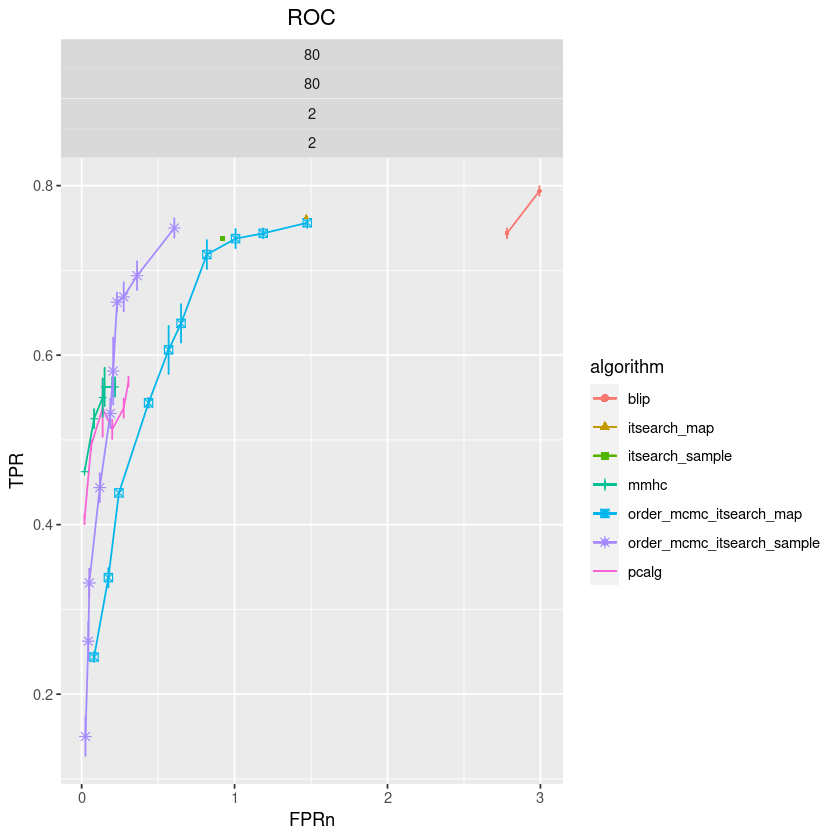

In [172]:
ggplot() +
# PC algorithm
geom_errorbar(data = sum_roc_pcalg,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_pcalg,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_pcalg,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) + 
# geom_text(data = sum_roc_pcalg,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                label=alpha, col=algorithm),
#          check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02
#          ) +

# Max-min hill- climbing 
geom_errorbar(data = sum_roc_mmhc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_mmhc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_mmhc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) + 
# geom_text(data = sum_roc_mmhc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                label=alpha, col=algorithm),
#          check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02
#          ) +

# Order mcmc
geom_errorbar(data = sumROC_order_mcmc,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sumROC_order_mcmc,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sumROC_order_mcmc,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 2) +
# geom_text(data = sumROC_order_mcmc,
#            aes(x = FPRn_median, 
#                y = TPR_q3,               
#                col = algorithm, label=threshold),
#            check_overlap = TRUE,
#           nudge_x=-0.02,
#          nudge_y=0.02) +

# Iterative search
geom_errorbar(data = sum_roc_itsearch,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_itsearch,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_itsearch,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) +
# Blip
geom_errorbar(data = sum_roc_blip,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_blip,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_blip,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) +
# Gobnilp
geom_errorbar(data = sum_roc_gobnilp,
               aes(x = FPRn_median,
                   ymin = TPR_q1, 
                   ymax = TPR_q3, 
                   col = algorithm), 
               width = 0.01) +
 geom_path(data = sum_roc_gobnilp,
           aes(x = FPRn_median, 
               y = TPR_median,
               col = algorithm)) +
 geom_point(data = sum_roc_gobnilp,
            aes(x = FPRn_median, 
                y = TPR_median,               
                col = algorithm, 
                shape = algorithm), 
                size = 1) +
## Subplot
facet_wrap(dim ~ sample_size + N + avparents, scales="free_x") +
# Titles etc
xlab("FPRn") +
ylab("TPR") +
ggtitle("ROC") +
theme(plot.title = element_text(hjust = 0.5))
ggsave(file=file.path("ROC.eps"))

Saving 6.67 x 6.67 in image



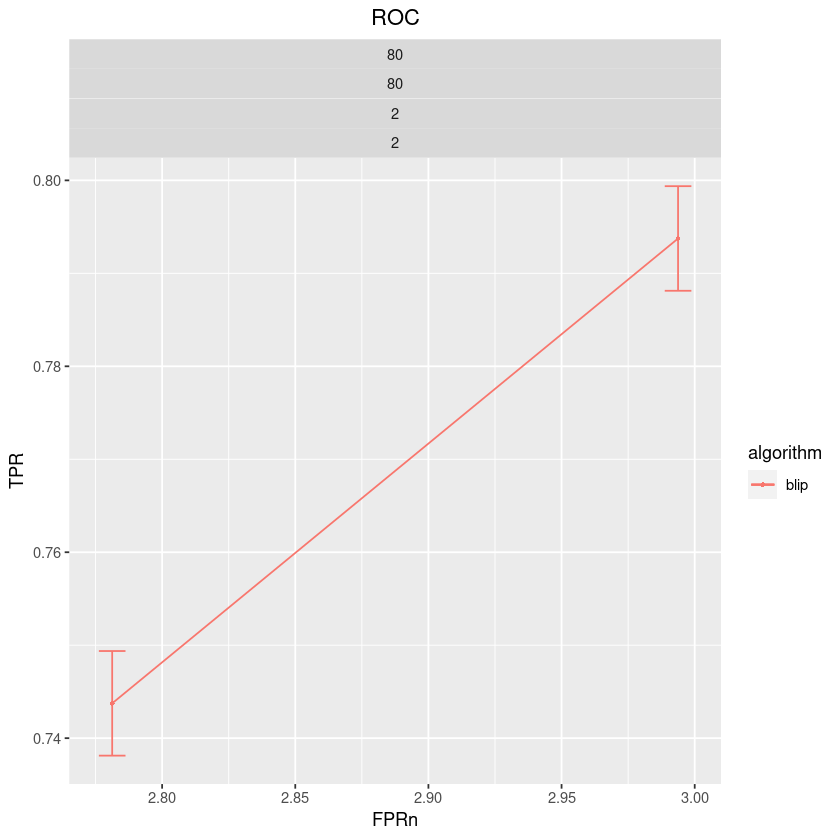

In [170]:
ggplot() +
# PC algorithm


geom_errorbar(data = sum_roc_blip,
              aes(x = FPRn_median,
                  ymin = TPR_q1, 
                  ymax = TPR_q3, 
                  col = algorithm), 
              width = 0.01) +
geom_path(data = sum_roc_blip,
          aes(x = FPRn_median, 
              y = TPR_median,
              col = algorithm)) +
geom_point(data = sum_roc_blip,
           aes(x = FPRn_median, 
               y = TPR_median,               
               col = algorithm, 
               shape = algorithm), 
               size = 1) +
# Gobnilp
geom_errorbar(data = sum_roc_gobnilp,
               aes(x = FPRn_median,
                   ymin = TPR_q1, 
                   ymax = TPR_q3, 
                   col = algorithm), 
               width = 0.01) +
 geom_path(data = sum_roc_gobnilp,
           aes(x = FPRn_median, 
               y = TPR_median,
               col = algorithm)) +
 geom_point(data = sum_roc_gobnilp,
            aes(x = FPRn_median, 
                y = TPR_median,               
                col = algorithm, 
                shape = algorithm), 
                size = 1) +
## Subplot
facet_wrap(dim ~ sample_size + N + avparents, scales="free_x") +
# Titles etc
xlab("FPRn") +
ylab("TPR") +
ggtitle("ROC") +
theme(plot.title = element_text(hjust = 0.5))
ggsave(file=file.path("ROC.eps"))

Saving 6.67 x 6.67 in image



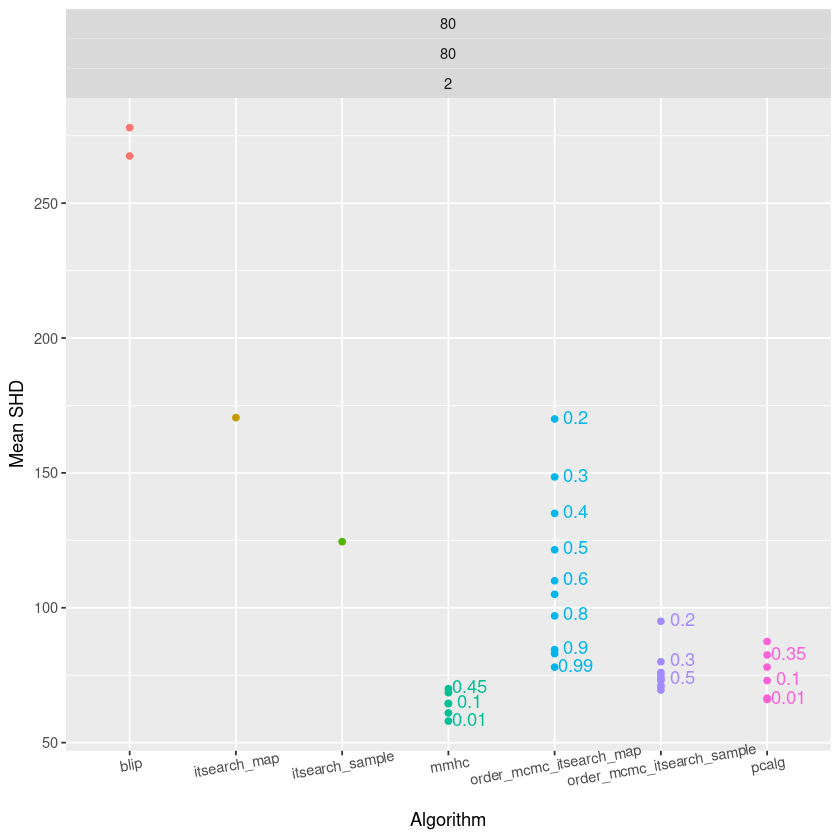

In [171]:
ggplot() + 
geom_point(data = sumROC_order_mcmc,
          aes(x = algorithm,
              y = SHD_mean,
              col = algorithm)) +
geom_text(data = sumROC_order_mcmc,
          aes(x = algorithm, 
               y = SHD_mean,               
                col = algorithm, label=threshold),
            check_overlap = TRUE,
           nudge_x=0.2,
          nudge_y=0.9) +

geom_point(data = sum_roc_pcalg,
          aes(x = algorithm,
              y = SHD_mean,
              col = algorithm)) +
geom_text(data = sum_roc_pcalg,
          aes(x = algorithm, 
               y = SHD_mean,               
                col = algorithm, label=alpha),
            check_overlap = TRUE,
           nudge_x=0.2,
          nudge_y=0.9) +

geom_point(data = sum_roc_mmhc,
          aes(x = algorithm,
              y = SHD_mean,
              col = algorithm)) +
geom_text(data = sum_roc_mmhc,
          aes(x = algorithm, 
               y = SHD_mean,               
                col = algorithm, label=alpha),
            check_overlap = TRUE,
           nudge_x=0.2,
          nudge_y=0.9) +

geom_point(data = sum_roc_blip,
          aes(x = algorithm,
              y = SHD_mean,
              col = algorithm)) +
geom_point(data = sum_roc_itsearch,
          aes(x = algorithm,
              y = SHD_mean,
              col = algorithm)) +
theme(axis.text.x = element_text(angle = 10), legend.position = "none") +
facet_wrap(dim ~ sample_size + N , scales="free_x") +
ylab("Mean SHD") +
xlab("Algorithm") 
ggsave(file=file.path("SHD.eps"))

## Logscores

Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing missing values (geom_text).”
Saving 6.67 x 6.67 in image

Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing missing values (geom_text).”


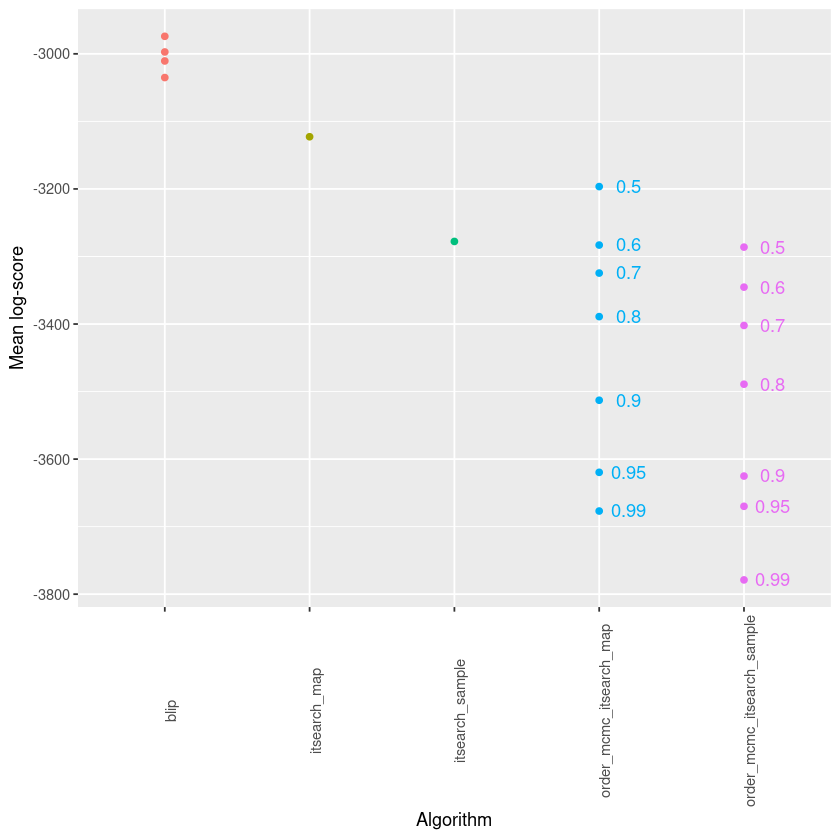

In [151]:
ggplot() + 
geom_point(data = sumROC_order_mcmc,
          aes(x = algorithm,
              y = logscore_mean,
              col = algorithm)) +
geom_text(data = sumROC_order_mcmc,
          aes(x = algorithm, 
               y = logscore_mean,               
                col = algorithm, label=threshold),
            check_overlap = TRUE,
           nudge_x=0.2,
          nudge_y=0.9) +

#geom_point(data = sum_roc_pcalg,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
#geom_point(data = sum_roc_mmhc,
#          aes(x = algorithm,
#              y = logscore_mean,
#              col = algorithm)) +
geom_point(data = sum_roc_blip,
          aes(x = algorithm,
              y = logscore_mean,
              col = algorithm)) +
geom_point(data = sum_roc_itsearch,
          aes(x = algorithm,
              y = logscore_mean,
              col = algorithm)) +
theme(axis.text.x = element_text(angle = 90),
      legend.position = "none") +
#facet_wrap(dim ~ sample_size + N , scales="free_x") +
ylab("Mean log-score") +
xlab("Algorithm") 
ggsave(file=file.path("logscore.eps"))


## Times

Saving 6.67 x 6.67 in image



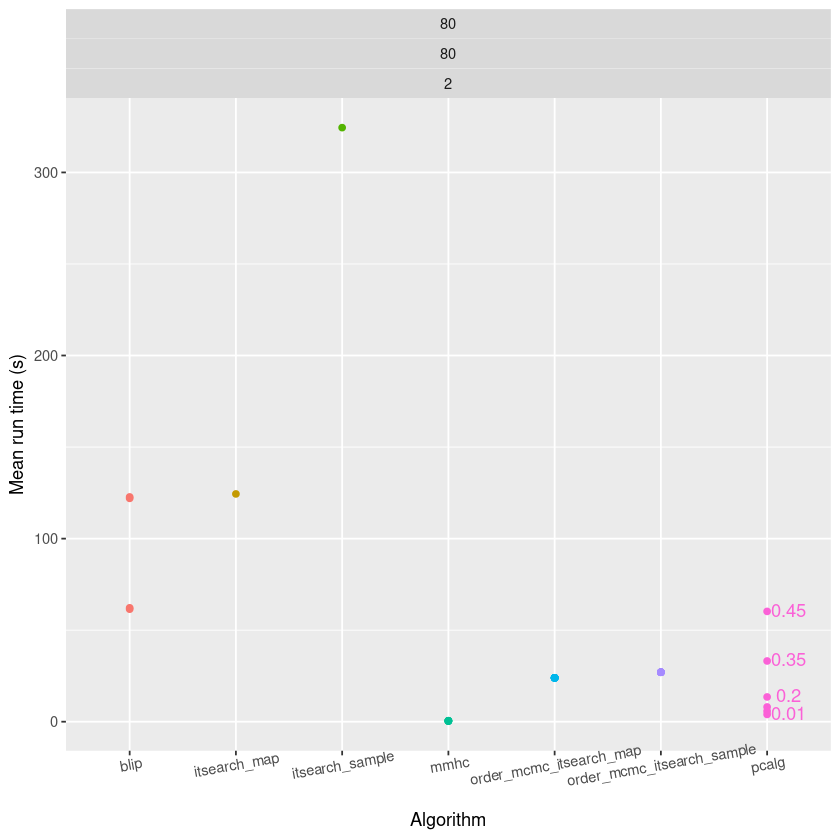

In [152]:
ggplot() + 
geom_point(data = sumROC_order_mcmc,
          aes(x = algorithm,
              y = time_mean,
              col = algorithm)) +
geom_point(data = sum_roc_pcalg,
          aes(x = algorithm,
              y = time_mean,
              col = algorithm)) +
geom_text(data = sum_roc_pcalg,
          aes(x = algorithm, 
               y = time_mean,               
                col = algorithm, label=alpha),
            check_overlap = TRUE,
           nudge_x=0.2,
          nudge_y=0.9) +

geom_point(data = sum_roc_mmhc,
          aes(x = algorithm,
              y = time_mean,
              col = algorithm)) +
geom_point(data = sum_roc_blip,
          aes(x = algorithm,
              y = time_mean,
              col = algorithm)) +
geom_point(data = sum_roc_itsearch,
          aes(x = algorithm,
              y = time_mean,
             col = algorithm)) +
theme(axis.text.x = element_text(angle = 10), legend.position = "none") +
facet_wrap(dim ~ sample_size + N , scales="free_x") +
ylab("Mean run time (s)") +
xlab("Algorithm") 
ggsave(file=file.path("runtimes.eps"))

In [ ]:
sum_roc_pcalg